Model Training and Evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

from sklearn.preprocessing import MinMaxScaler

# Load the cleaned & engineered dataset
df = pd.read_csv('../data/final_train_FD001.csv')
df.head()

# Recreate the list of features
features = [col for col in df.columns if col.startswith('sensor_') or col.startswith('op_setting')]

# Fit scaler again
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Optionally verify
print("Scaler re-fitted on current dataframe.")


Scaler re-fitted on current dataframe.


In [3]:
# Split into Features and Target
# Drop irrelevant columns
X = df.drop(columns=['unit_number', 'time_in_cycles', 'RUL'])  # Features
y = df['RUL']  # Target variable

# Simple random split (can do by engine for more realism later)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Define Evaluation Function (For All Models)

def evaluate_model(y_true, y_pred, name="Model"):
    print(f"\n {name} Evaluation:")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²  :", r2_score(y_true, y_pred))


In [5]:
#Train + Evaluate

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# Evaluation
evaluate_model(y_test, y_pred_lr, name="Linear Regression")


# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# Evaluation
evaluate_model(y_test, y_pred_rf, name="Random Forest")


# xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
# Evaluation
evaluate_model(y_test, y_pred_xgb, name="XGBoost")




 Linear Regression Evaluation:
MAE : 33.87638504654054
RMSE: 44.16658689941548
R²  : 0.5730411749458179

 Random Forest Evaluation:
MAE : 28.85133026411437
RMSE: 40.510632699521395
R²  : 0.640799966526618

 XGBoost Evaluation:
MAE : 28.91521644592285
RMSE: 40.63603215589583
R²  : 0.6385726928710938


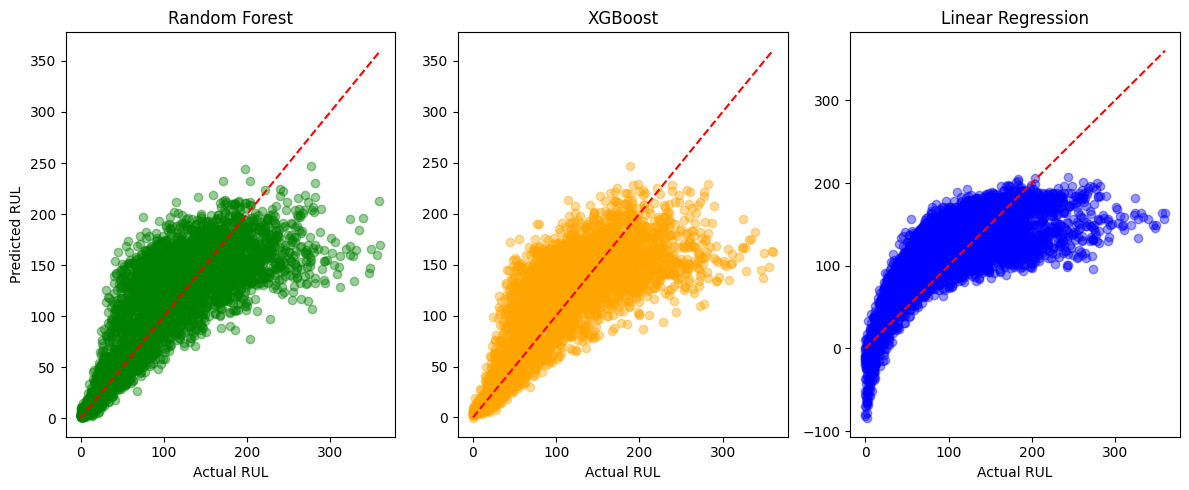

In [6]:
#Compare All Predictions Visually

# Scatter plot for actual vs predicted
plt.figure(figsize=(12, 5))

# Random Forest
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.4, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")

# XGBoost
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.4, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("XGBoost")
plt.xlabel("Actual RUL")

# Linear Regression
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lr, alpha=0.4, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Linear Regression")
plt.xlabel("Actual RUL")

plt.tight_layout()
plt.show()


#Build and Launch a Streamlit App

In [14]:
import os
#print("Current Working Directory:", os.getcwd())
os.makedirs('../models', exist_ok=True)

# Save Best Model (For Streamlit Deployment)
#Save Random Forest model using joblib
import joblib

joblib.dump(rf, '../models/rf_model.pkl')
print(" Random Forest model saved to ../models/rf_model.pkl")

joblib.dump(xgb, '../models/xgb_model.pkl')
print(" XGBoost model saved to ../models/xgb_model.pkl")

joblib.dump(lr, '../models/lr_model.pkl')
print(" XGBoost model saved to ../models/lr_model.pkl")



 Random Forest model saved to ../models/rf_model.pkl
 XGBoost model saved to ../models/xgb_model.pkl
 XGBoost model saved to ../models/lr_model.pkl


In [8]:
joblib.dump(scaler, '../models/scaler.pkl')
print(" Scaler saved to ../models/scaler.pkl")

#Save the list of input features used by the model:
features = X.columns.tolist()

with open('../models/feature_list.txt', 'w') as f:
    for item in features:
        f.write("%s\n" % item)

print(" Feature list saved to ../models/feature_list.txt")



 Scaler saved to ../models/scaler.pkl
 Feature list saved to ../models/feature_list.txt


In [9]:
# Confirm model works before deployment
# Reload the model
model = joblib.load('../models/rf_model.pkl')

# Predict again
#sample_pred = model.predict([X_test.iloc[0]])  # Must be in 2D format
#print("Sample RUL Prediction:", sample_pred[0])

sample_input = X_test.iloc[[0]]  # This is still a DataFrame
sample_pred = model.predict(sample_input)
print(" Sample RUL Prediction:", sample_pred[0])

#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
#sample_pred = model.predict([X_test.iloc[0]])
#print("Sample RUL Prediction:", sample_pred[0])

 Sample RUL Prediction: 115.57


App will:
1. Load trained model (rf_model.pkl)
2. Accept engine sensor inputs from the user
3. Predict Remaining Useful Life (RUL)
4. Display the result and optional visualizations

In [10]:
#Since we already saved the feature list and app.py already created so will update code in app.
#then current directory as app, # cd app use code  #appstreamlit run app.py

Feature Importance & Model Interpretation

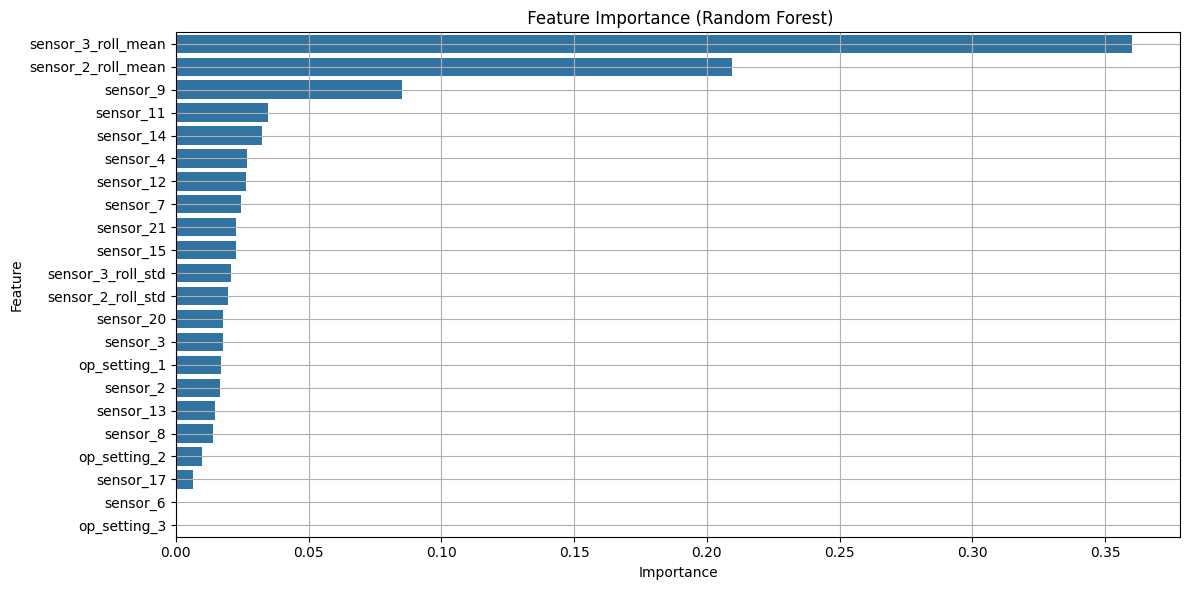

In [11]:
#Global Feature Importance (Random Forest)
#This gives an overview of most influential sensors/settings.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the best model (Random Forest)
rf_importances = rf.feature_importances_
features = X_train.columns

# Create DataFrame
fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Plot - Shows overall ranking of inputs
plt.figure(figsize=(12, 6))
#sns.barplot(x='Importance', y='Feature', data=fi_df, palette="viridis")
#sns.barplot(x='Importance', y='Feature', data=fi_df, hue='Feature', dodge=False, palette='viridis', legend=False)
sns.barplot(x='Importance', y='Feature', data=fi_df)

plt.title(" Feature Importance (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


subset


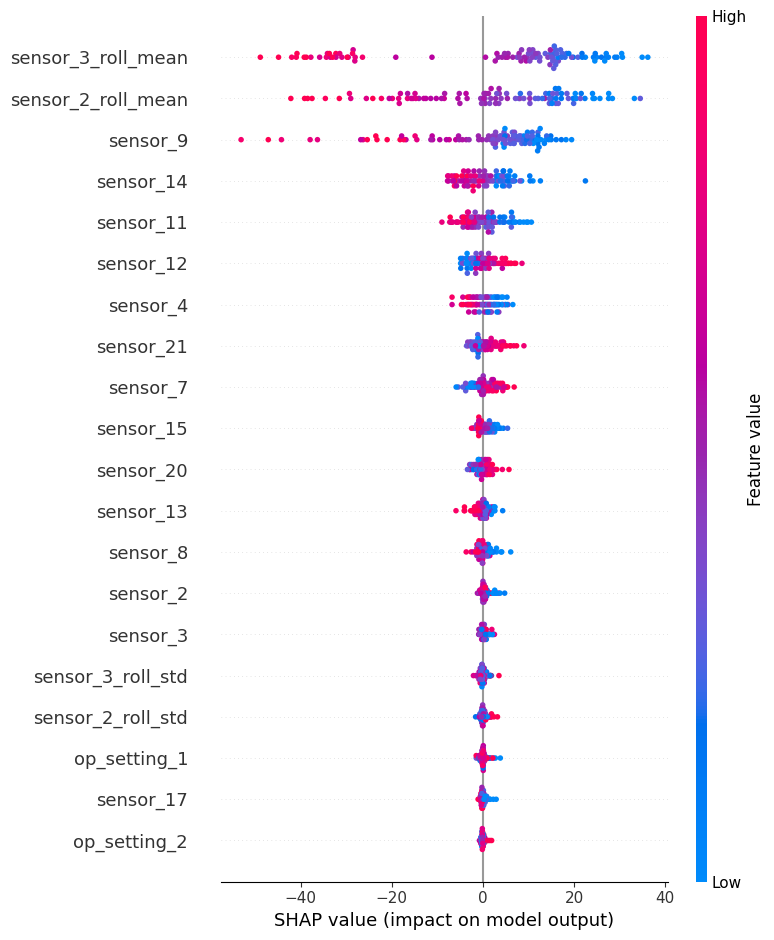

'\n# Calculate SHAP values only for a small subset\nsubset = X_test.sample(100, random_state=42)\nshap_values = explainer.shap_values(subset)\n\n# Plot\nshap.summary_plot(shap_values, subset)\n'

In [12]:
# This shows top features by average impact across all predictions
#Explains influence direction (±)
import shap

# Initialize explainer for Random Forest
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values
#shap_values = explainer.shap_values(X_test)
subset = X_test.sample(100, random_state=42)
print('subset')
shap_values = explainer.shap_values(subset)

# Global explanation plot
#shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, subset)

'''
# Calculate SHAP values only for a small subset
subset = X_test.sample(100, random_state=42)
shap_values = explainer.shap_values(subset)

# Plot
shap.summary_plot(shap_values, subset)
'''

SHAP Values (Local + Global Explanation)
#SHAP gives deeper insight: how much each feature pushed a prediction up or down.

In [13]:
#Force Plot for One Prediction
# Just one test sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


predictive_maintenance/
├── app/
│   └── app.py               ← Streamlit main file
├── models/
│   ├── rf_model.pkl         ← Best model
│   ├── scaler.pkl           ← MinMaxScaler
│   └── feature_list.txt     ← Used feature list
├── data/
│   └── (sample test files)


Build a Better Web Dashboard- updated code in app.py 

In [15]:
import gdown